In [196]:
import time
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn_extra.cluster import KMedoids

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
#from konlpy.tag import Komoran

#import pandas_datareader as pdr
from datetime import datetime

from scipy.cluster.hierarchy import linkage 
from scipy.cluster.hierarchy import dendrogram 

from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

import scipy.spatial.distance as ssd

#from gensim.models import Word2Vec as w_to_v

In [197]:
df = pd.read_csv('../datadf.csv', encoding = 'euc-kr')
df_price = pd.read_pickle('../fkl/price_normal.fkl')
df_dtw_matrix = pd.read_pickle('../fkl/dtw_matrix.fkl')

df_finance = pd.read_pickle('../fkl/financial_i_log_categoric.fkl')
df_price = df_price.dropna(axis = 0)

In [324]:
from scipy.spatial import distance_matrix

In [325]:
## 대칭행렬 min_max 정규화하는 함수
def normalize(distance_matrix):
    # 행렬 반쪽만 num_list에 추가
    num_list = []
    for i in range(len(distance_matrix)):
        for j in range(i+1, len(distance_matrix)):
            num_list.append(distance_matrix[i][j])
            
    num_array = np.array(num_list)
    max_num = num_array.max() # 평균
    min_num = num_array.min() # 표준편차
    
    
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix)):
            if distance_matrix[i][j] != 0:
                distance_matrix[i][j] = (distance_matrix[i][j]-min_num)/(max_num - min_num)
    
    return distance_matrix

In [326]:
distance_matrix_text = pd.DataFrame(distance_matrix(centers_text, centers_text))
distance_matrix_text

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.472188,0.549876,0.660371,0.604808,0.612707,0.613227,0.601940,0.710100,0.590347
1,0.472188,0.000000,0.421870,0.611931,0.453208,0.490067,0.477519,0.464760,0.616506,0.441820
2,0.549876,0.421870,0.000000,0.678706,0.569061,0.562239,0.596743,0.596737,0.660370,0.565430
3,0.660371,0.611931,0.678706,0.000000,0.726047,0.728917,0.729461,0.736884,0.804335,0.678438
4,0.604808,0.453208,0.569061,0.726047,0.000000,0.611008,0.598384,0.515562,0.726476,0.554901
5,0.612707,0.490067,0.562239,0.728917,0.611008,0.000000,0.605638,0.640762,0.743594,0.604184
6,0.613227,0.477519,0.596743,0.729461,0.598384,0.605638,0.000000,0.607596,0.736299,0.583269
7,0.601940,0.464760,0.596737,0.736884,0.515562,0.640762,0.607596,0.000000,0.705550,0.597920
8,0.710100,0.616506,0.660370,0.804335,0.726476,0.743594,0.736299,0.705550,0.000000,0.719799
9,0.590347,0.441820,0.565430,0.678438,0.554901,0.604184,0.583269,0.597920,0.719799,0.000000


In [327]:
distance_matrix_price = pd.DataFrame(distance_matrix(centers_price, centers_price))
distance_matrix_price

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,17.816468,14.564959,17.254777,17.966176,15.221972,19.645335,10.608805,12.342662,22.517423,18.715288,17.295430,14.412369,14.081656,17.503217
1,17.816468,0.000000,13.854266,23.836082,12.577386,7.981596,7.827156,12.254754,10.659477,10.579959,24.355790,26.330310,19.228182,18.271782,7.481774
2,14.564959,13.854266,0.000000,14.215343,20.003462,8.455017,19.211506,13.888125,12.220445,19.290566,16.321027,20.226732,9.778436,9.849012,18.198334
3,17.254777,23.836082,14.215343,0.000000,25.177754,18.628701,26.257819,19.461000,20.026345,25.674792,10.727430,12.145551,9.345278,11.405944,25.546667
4,17.966176,12.577386,20.003462,25.177754,0.000000,15.392723,7.926245,12.111137,17.554957,11.029305,24.178254,22.903395,22.367712,23.449979,11.266306
5,15.221972,7.981596,8.455017,18.628701,15.392723,0.000000,13.546150,10.456250,10.165032,15.185666,20.843841,23.323734,13.166025,14.443639,12.566944
6,19.645335,7.827156,19.211506,26.257819,7.926245,13.546150,0.000000,13.490894,14.702737,7.467284,25.803304,25.873912,22.711774,22.118189,5.994086
7,10.608805,12.254754,13.888125,19.461000,12.111137,10.456250,13.490894,0.000000,9.854284,17.766760,21.660765,20.256356,15.489045,16.157996,11.246516
8,12.342662,10.659477,12.220445,20.026345,17.554957,10.165032,14.702737,9.854284,0.000000,18.198972,22.015727,22.760195,15.466376,12.080039,10.335059
9,22.517423,10.579959,19.290566,25.674792,11.029305,15.185666,7.467284,17.766760,18.198972,0.000000,23.425057,25.211904,22.612824,22.670138,12.014713


In [328]:
distance_matrix_finance = pd.DataFrame(distance_matrix(centers_finance, centers_finance))
distance_matrix_finance

,0,1,2,3,4
0,0.000000,9.060419,6.974976,5.083469,2.689992
1,9.060419,0.000000,14.385248,9.551765,10.510348
2,6.974976,14.385248,0.000000,10.540177,4.706058
3,5.083469,9.551765,10.540177,0.000000,6.795907
4,2.689992,10.510348,4.706058,6.795907,0.000000


In [1]:
distance_matrix_text = normalize(distance_matrix_text)
distance_matrix_price = normalize(distance_matrix_price)
distance_matrix_finance = normalize(distance_matrix_finance)

NameError: name 'normalize' is not defined

In [330]:
# distance_matrix_text

In [331]:
# distance_matrix_price

In [332]:
# distance_matrix_finance

In [333]:
# df_text_result --> 기업개요 클러스터링 결과 200 x 200
# df_price_result --> 주가변동 클러스터링 결과 194 x 194
# df_finance_result --> 재무지표 클러스터링 결과 198 x 198

df_merge_result = pd.merge(df_text_result, df_price_result, left_on='name', right_on='name', how='inner')
df_merge_result = pd.merge(df_merge_result, df_finance_result, left_on='name', right_on='name', how='inner')
df_merge_result = df_merge_result.fillna(100)
df_merge_result = df_merge_result.astype({'price_clusters':int, 'finance_clusters':int})



In [334]:
df_dist_new = pd.DataFrame(index = df_merge_result.index, columns = df_merge_result.index)
df_dist_new

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
# df_clusters_result --> 클러스터링 결과 left join으로 합친 것 200 x 200, null 값은 100으로 채움
# normal_dist_text --> text 클러스터링 distance matrix
# normal_dist_price --> 주가 클러스터링 distance matrix

# 거리의 합으로 새로운 200x200 distance matrix 만들어보자

## 가중치
weight_text = 4
weight_price = 5
weight_finance = 3

for i in range(len(df_merge_result)):
    for j in range(len(df_merge_result)):
        distance = 0
        try: 
            text_cluster_1 = df_merge_result['text_clusters'][i] # 첫 번째 기업의 개요 클러스터
            text_cluster_2 = df_merge_result['text_clusters'][j] # 두 번째 기업의 개요 클러스터
            distance += weight_text * distance_matrix_text[text_cluster_1][text_cluster_2] # 개요 클러스터 거리 * weight
        except KeyError:
            print('{}, {}의 text 거리가 계산되지 않습니다.'.format(df_merge_result['name'][i], df_merge_result['name'][j]))
            
        try:
            price_cluster_1 = df_merge_result['price_clusters'][i] # 첫 번째 기업의 주가 클러스터
            price_cluster_2 = df_merge_result['price_clusters'][j] # 두 번째 기업의 주가 클러스터
            distance += weight_price * distance_matrix_price[price_cluster_1][price_cluster_2] # 주가 클러스터 거리 * weight
        except KeyError:
            print('{}, {}의 price 거리가 계산되지 않습니다.'.format(df_merge_result['name'][i], df_merge_result['name'][j]))
            
        try:
            finance_cluster_1 = df_merge_result['finance_clusters'][i] # 첫 번째 기업의 재무 클러스터
            finance_cluster_2 = df_merge_result['finance_clusters'][j] # 두 번째 기업의 재무 클러스터
            distance += weight_finance * distance_matrix_finance[finance_cluster_1][finance_cluster_2] # 재무 클러스터 거리 * weight
        except KeyError:
            print('{}, {}의 finance 거리가 계산되지 않습니다.'.format(df_merge_result['name'][i], df_merge_result['name'][j]))
        
        df_dist_new[i][j] = distance
        

In [336]:
df_dist_new

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,0.0,2.077464,2.889075,5.794823,0.605061,4.257214,0.0,2.033103,1.468539,6.590442,...,2.925939,3.444888,3.444888,2.005374,2.064617,4.110043,1.474067,2.076974,6.089625,7.227644
1,2.077464,0.0,5.419089,7.775834,0.947798,6.364792,2.077464,4.110566,3.998553,4.814607,...,4.327808,5.236989,5.236989,2.47621,3.856718,3.829678,1.944903,3.478844,4.599575,5.737595
2,2.889075,5.419089,0.0,4.633057,4.332969,0.450691,2.889075,4.415601,2.430403,7.401195,...,3.977203,2.803686,2.803686,4.159477,1.991188,5.767907,2.772479,4.551703,6.855904,8.531593
3,5.794823,7.775834,4.633057,0.0,6.92845,3.489496,5.794823,7.51021,5.321478,4.716625,...,5.09749,4.889774,4.889774,7.127307,4.431019,7.158583,5.977189,5.788853,7.168937,4.674586
4,0.605061,0.947798,4.332969,6.92845,0.0,5.650136,0.605061,2.638164,2.912433,5.505344,...,3.769723,4.829459,4.829459,2.510731,3.449188,3.948506,1.979425,2.920758,5.328175,6.466195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,4.110043,3.829678,5.767907,7.158583,3.948506,6.217565,4.110043,4.274093,4.298032,6.983674,...,2.636022,4.331129,4.331129,2.952206,3.038359,0.0,1.76955,2.525908,4.280041,5.89451
190,1.474067,1.944903,2.772479,5.977189,1.979425,3.766582,1.474067,1.967204,1.47481,6.584821,...,0.949094,1.067301,1.067301,0.327746,1.067301,1.76955,0.0,1.27684,4.122228,6.157824
191,2.076974,3.478844,4.551703,5.788853,2.920758,4.855628,2.076974,1.711059,1.53929,7.595939,...,1.539398,2.830796,2.830796,0.949094,1.619144,2.525908,1.27684,0.0,5.046016,6.692331
192,6.089625,4.599575,6.855904,7.168937,5.328175,6.74369,6.089625,6.853407,6.539398,4.523942,...,3.506617,4.880796,4.880796,5.661626,4.880796,4.280041,4.122228,5.046016,0.0,2.494351


In [302]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters = 10, metric = 'precomputed', method = 'pam', init = 'k-medoids++', random_state = 42, max_iter =2000)

In [303]:
kmedoids.fit(df_dist_new)

KMedoids(init='k-medoids++', max_iter=2000, method='pam', metric='precomputed',
         n_clusters=10, random_state=42)

<IPython.core.display.Javascript object>


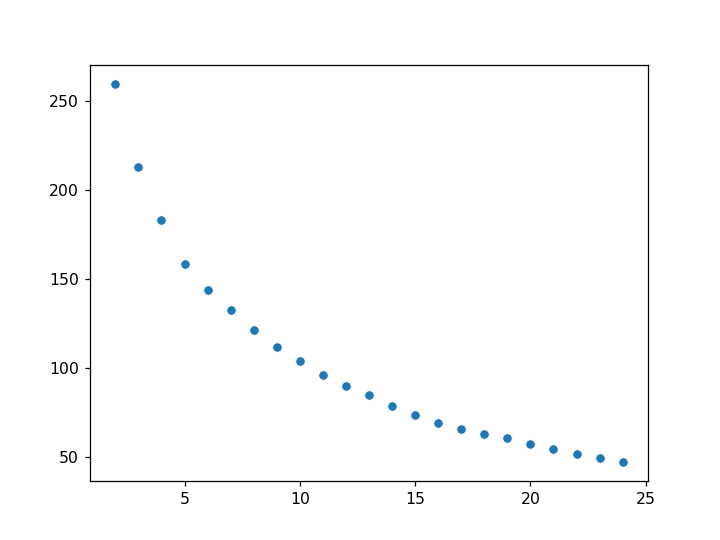

<AxesSubplot:>

In [283]:
# elbow 

clusters_range = list(range(2, 25))
inertia = []

for i in list(range(2, 25)):
    tskmeans =KMedoids(n_clusters = i, metric = 'precomputed', method = 'pam', init = 'k-medoids++', random_state = 42, max_iter =300)
    tskmeans.fit(df_dist_new)
    inertia.append(tskmeans.inertia_)

sns.scatterplot(x=clusters_range, y=inertia)

In [304]:
kmedoids_clusters = kmedoids.labels_
kmedoids_clusters

array([4, 8, 7, 7, 8, 7, 4, 4, 4, 3, 0, 4, 2, 4, 5, 0, 8, 2, 4, 4, 1, 5,
       2, 2, 8, 7, 8, 0, 0, 4, 2, 0, 4, 6, 5, 1, 0, 0, 2, 2, 0, 8, 8, 4,
       9, 1, 0, 0, 8, 1, 0, 0, 5, 0, 0, 8, 1, 0, 7, 8, 0, 2, 7, 2, 4, 4,
       3, 2, 1, 0, 2, 0, 5, 0, 0, 0, 6, 8, 2, 4, 0, 5, 1, 1, 2, 8, 3, 0,
       0, 0, 8, 3, 4, 0, 8, 9, 4, 2, 0, 2, 4, 1, 4, 0, 8, 0, 0, 0, 0, 0,
       0, 0, 2, 1, 0, 7, 5, 0, 0, 4, 0, 5, 4, 0, 9, 0, 5, 0, 0, 7, 0, 1,
       3, 7, 0, 8, 5, 0, 4, 0, 8, 1, 5, 0, 0, 0, 0, 0, 0, 6, 1, 8, 3, 8,
       0, 0, 0, 1, 5, 0, 4, 0, 5, 0, 0, 9, 0, 0, 1, 0, 0, 5, 0, 0, 4, 0,
       3, 0, 0, 6, 0, 9, 5, 1, 5, 0, 0, 1, 0, 1, 1, 0, 6, 9], dtype=int64)

In [305]:
kmedoids_med = kmedoids.medoid_indices_
kmedoids_med

array([106,  82,  84,   9,  65,  81, 149, 129, 153, 124])

In [307]:
df_merge_result["merge_cluster"]= kmedoids_clusters

df_groupby_cluster = df_merge_result.groupby('merge_cluster')
#result = dict(list((df_groupby_cluster['name'])))

groupby_list = df_merge_result.groupby('merge_cluster')['name'].apply(list)

for i in groupby_list:
    print(i)
    print('\n')

['POSCO', 'SK텔레콤', 'HMM', '두산중공업', 'S-Oil', '고려아연', '대한항공', 'KT', 'SKC', 'LG유플러스', '강원랜드', '코웨이', '현대제철', '현대건설', '한국타이어앤테크놀로지', '현대중공업지주', 'GS', '한국가스공사', '한솔케미칼', '쌍용C&E;', '두산밥캣', '호텔신라', '팬오션', 'OCI', '효성첨단소재', 'KCC', 'BGF리테일', 'CJ', '제일기획', '포스코인터내셔널', '대우건설', '한샘', '효성티앤씨', '현대로템', '현대미포조선', '한화', '신세계', '코오롱인더', '한화에어로스페이스', '효성', '롯데정밀화학', '영원무역', '현대엘리베이', '한전KPS', 'LS ELECTRIC', '아시아나항공', '동원시스템즈', '동국제강', '두산', '금호타이어', '코스맥스', '롯데칠성', '롯데관광개발', '영풍', 'SK네트웍스', '신세계인터내셔날', '태광산업', 'CJ CGV', 'KG동부제철', 'LX인터내셔널', '화승엔터프라이즈', '한섬', '휴켐스', '오리온홀딩스', 'LIG넥스원', '쿠쿠홈시스', '한세실업', '풍산', '현대그린푸드', '삼양홀딩스', '쿠쿠홀딩스', '동원F&B;', '넥센타이어', 'LX하우시스']


['LG', '아모레퍼시픽', '한국조선해양', 'LG디스플레이', '금호석유', '아모레G', 'GS리테일', 'CJ대한통운', '롯데쇼핑', '하이트진로', '현대백화점', '한국앤컴퍼니', '아이에스동서', '더블유게임즈', '한국콜마', '동원산업', 'SNT모티브', '현대두산인프라코어', '롯데하이마트']


['KB금융', '신한지주', '삼성생명', '하나금융지주', '삼성화재', '우리금융지주', '기업은행', '한국금융지주', 'DB손해보험', '삼성증권', '삼성카드', 'NH투자증권', '메리츠증권', '한화생명', 'BNK금융지주', '현대해상']


['셀트리온', '유한양행', '한미

In [308]:
df_join = pd.merge(df, df_merge_result[['name', 'merge_cluster']], left_on='name', right_on='name', how='inner')

df_groupby_cluster = df_join.groupby('merge_cluster')
#result = dict(list((df_groupby_cluster['name'])))

groupby_list = df_join.groupby('merge_cluster')['labels_kse'].apply(list)

for i in groupby_list:
    print(i)
    print('\n')

['철강및금속', '통신업', '운수창고', '기계', '화학', '철강및금속', '운수창고', '통신업', '화학', '통신업', '서비스업', '서비스업', '철강및금속', '건설업', '화학', '화학', '금융업', '전기가스업', '화학', '비금속광물', '기계', '유통업', '운수창고', '화학', '화학', '화학', '유통업', '금융업', '서비스업', '유통업', '건설업', '유통업', '화학', '운수장비', '운수장비', '화학', '유통업', '화학', '운수장비', '금융업', '화학', '유통업', '기계', '건설업', '전기,전자', '운수창고', '화학', '철강및금속', '서비스업', '화학', '화학', '음식료품', '서비스업', '철강및금속', '유통업', '유통업', '화학', '서비스업', '철강및금속', '유통업', '제조업', '섬유,의복', '화학', '금융업', '기계', '서비스업', '섬유,의복', '철강및금속', '유통업', '금융업', '금융업', '음식료품', '화학', '화학']


['금융업', '화학', '운수장비', '전기,전자', '화학', '화학', '유통업', '운수창고', '유통업', '음식료품', '유통업', '금융업', '비금속광물', '서비스업', '화학', nan, '운수장비', '기계', '유통업']


['금융업', '금융업', '보험', '금융업', '보험', '금융업', '은행', '금융업', '보험', '증권', '금융업', '증권', '증권', '보험', '금융업', '보험']


['의약품', '의약품', '의약품', '의약품', '금융업', '의약품', '의약품']


['전기,전자', '전기,전자', '운수장비', '운수장비', '운수장비', '화학', '전기,전자', '금융업', '전기,전자', '비금속광물', '기계', '전기,전자', '유통업', '건설업', '전기,전자', '운수장비', '운수장비', '기계', '전기,전자', '운수장비', '건설업',

In [309]:
df_merge_result.loc[kmedoids_med]

,name,text_clusters,price_clusters,finance_clusters,merge_cluster
106,포스코인터내셔널,1,1,2,0
82,GS리테일,1,3,2,1
84,메리츠증권,3,1,2,2
9,셀트리온,8,5,0,3
65,이마트,1,0,2,4
81,롯데지주,1,9,2,5
149,DL,1,2,2,6
129,대한전선,1,8,0,7
153,대한유화,1,6,2,8
124,SK케미칼,8,2,3,9


<IPython.core.display.Javascript object>


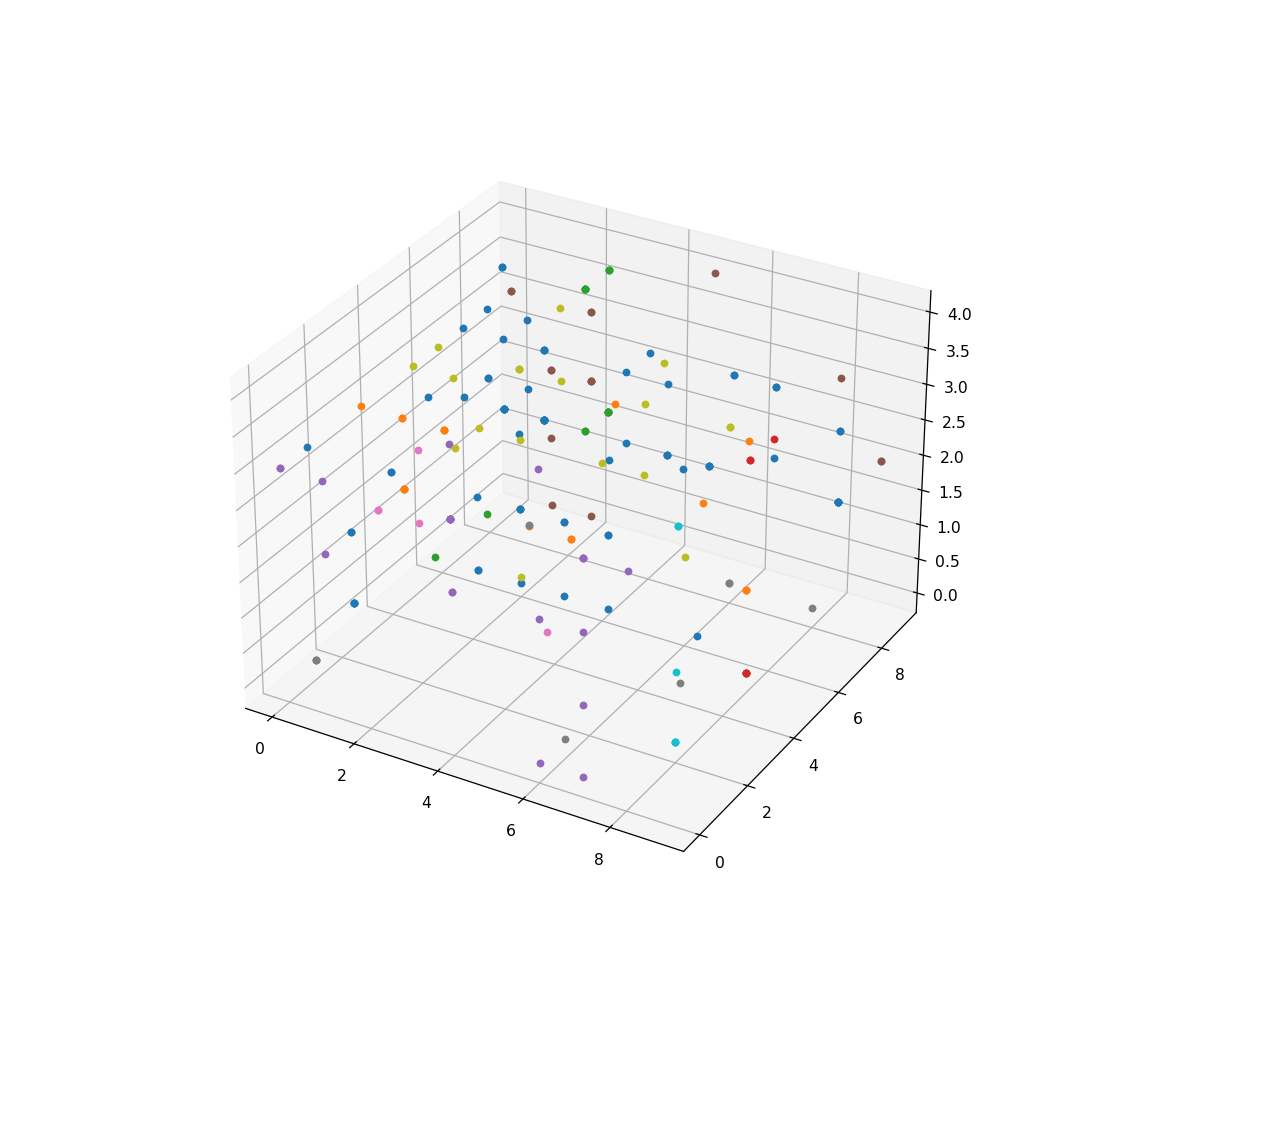

In [310]:
# PCA 차원 축소
%matplotlib notebook

xs, ys, zs = df_merge_result.iloc[:, 1], df_merge_result.iloc[:, 2], df_merge_result.iloc[:, 3]
clusters = df_merge_result['merge_cluster']
df_plot = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters))
groups = df_plot.groupby('label')


fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.margins(0.05)
colors = {0:'r', 1: 'b', 2: 'k', 3: 'm', 4: 'c', 5: 'g', 6: 'w'}
for idx, group in groups:
    ax.plot(group.x, group.y, group.z ,marker='o', linestyle='', ms=5, mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',
        which='both',
        bottom='off',
        top='off',
        labelbottom='off')
    ax.tick_params(        axis= 'y',
        which='both',
        left='off',
        top='off',
        labelleft='off')
    ax.tick_params(        axis= 'z',
        which='both',
        left='off',
        top='off',
        labelleft='off')



#ax.plot(centers_trans[:,0],centers_trans[:,1],centers_trans[:,2], c='y', zorder=100, marker='d', linestyle='')
plt.show()